In [2]:
id_ = 'Chen_Zhang_2020_NSCLC'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
type_label = 'level_2_transfered_label'


In [24]:
id_ = 'Deng_Liu_LUAD_2024'
type_label = 'assigned_cell_type'

In [4]:
import os
from pathlib import Path
import gdown

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

from ikarus import classifier, utils, data
import infercnvpy as cnv

In [5]:
def remove_by_str(x: pd.DataFrame, conts: str = 'H', keep_one: bool=True) -> pd.Series:
    """
    Filters rows in a Pandas DataFrame based on the presence of a specified 
    string in the 'chromosome' column.

    This function removes rows where the 'chromosome' column contains the specified
    string (default is 'H'). If all rows contain the specified string and `keep_one`
    is set to True, the function returns the first row of the DataFrame to ensure 
    that the result is not empty.

    Parameters:
    - x (pd.DataFrame): The DataFrame to process. Must include a 'chromosome' column.
    - conts (str, optional): The string to search for in the 'chromosome' column. 
      Rows containing this string will be removed. Defaults to 'H'.
    - keep_one (bool, optional): A flag to indicate whether to keep at least one 
      row in the resulting DataFrame, even if all rows contain the specified string.
      Defaults to True.

    Returns:
    - pd.DataFrame: A DataFrame with rows containing the specified string removed. 
      If `keep_one` is True and all rows contain the string, the first row of the 
      original DataFrame is returned.

    """
    non_conts = np.logical_not( x['chromosome'].str.contains(conts))
    if non_conts.sum() < 1 and keep_one:
        return x.iloc[0,:]
    else:
        return x.loc[non_conts, :].iloc[0,:]

In [6]:
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 488236 × 33336
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'Patient Number', 'Group', 'Sex', 'Age （years）', 'Current or former smoking', 'Cancer history', 'Tumor location', 'Tumor size（cm）', 'Pathology', 'Histological subtype', 'T stage', 'N stage', 'M stage', 'Pathological stage'
    var: 'features'
    obsm: 'X_tsne', 'X_umap'
    layers: 'data'

In [7]:
from pybiomart import Server

# Connect to the Ensembl biomart server
server = Server(host='http://www.ensembl.org')

# Select the appropriate dataset (e.g., human genes)
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Prepare the query
# Replace 'your_gene_symbols' with a list of your gene symbols
query = dataset.query(attributes=['external_gene_name', 'chromosome_name', 'start_position', 'end_position'])


# join_map_mart(query, adata.var , gene_annot='gene_symbol', how='inner')


In [8]:
gene_var = pd.merge(
        pd.DataFrame({'Gene name':adata.var.index}),
        query,
        how='left', on='Gene name', suffixes=('_xxx','_yyy'))
gene_var

,Gene name,Chromosome/scaffold name,Gene start (bp),Gene end (bp)
0,AL627309.1,NaN,NaN,NaN
1,AL627309.5,NaN,NaN,NaN
2,AP006222.2,NaN,NaN,NaN
3,LINC01409,1,778747.0,810065.0
4,FAM87B,1,817371.0,819837.0
...,...,...,...,...
36342,KRTAP17-1,17,41314912.0,41315710.0
36343,AC036222.2,NaN,NaN,NaN
36344,AC091180.4,NaN,NaN,NaN
36345,AC016383.3,NaN,NaN,NaN


In [9]:
gene_var.iloc[:,2].isnull().sum()


11482

In [10]:
gene_var.columns = ['Symbol', 'chromosome', 'start', 'end']
gene_var.loc[:,['start','end']] = gene_var.loc[:,['start','end']].astype('Int32')
gene_var['chromosome'] = gene_var['chromosome'].astype('category')
gene_var

,Symbol,chromosome,start,end
0,AL627309.1,NaN,<NA>,<NA>
1,AL627309.5,NaN,<NA>,<NA>
2,AP006222.2,NaN,<NA>,<NA>
3,LINC01409,1,778747,810065
4,FAM87B,1,817371,819837
...,...,...,...,...
36342,KRTAP17-1,17,41314912,41315710
36343,AC036222.2,NaN,<NA>,<NA>
36344,AC091180.4,NaN,<NA>,<NA>
36345,AC016383.3,NaN,<NA>,<NA>


In [11]:
#papermill_description=GroupChroms
gene_var = gene_var.groupby('Symbol')\
    .apply(lambda x: remove_by_str(x))\
    .reset_index(drop=True)
gene_var['chromosome'] = gene_var['chromosome'].astype('category')
gene_var

,Symbol,chromosome,start,end
0,A1BG,19,58345178,58353492
1,A1BG-AS1,19,58347718,58355455
2,A1CF,10,50799409,50885675
3,A2M,12,9067664,9116229
4,A2M-AS1,12,9065163,9068689
...,...,...,...,...
33331,ZXDC,3,126437601,126475891
33332,ZYG11A,1,52842511,52894998
33333,ZYG11B,1,52726453,52827336
33334,ZYX,7,143381295,143391111


In [12]:
adata.var = gene_var
adata.var

,Symbol,chromosome,start,end
0,A1BG,19,58345178,58353492
1,A1BG-AS1,19,58347718,58355455
2,A1CF,10,50799409,50885675
3,A2M,12,9067664,9116229
4,A2M-AS1,12,9065163,9068689
...,...,...,...,...
33331,ZXDC,3,126437601,126475891
33332,ZYG11A,1,52842511,52894998
33333,ZYG11B,1,52726453,52827336
33334,ZYX,7,143381295,143391111


In [13]:
adata.var.index = adata.var.Symbol
del adata.var['Symbol']
adata.var

,chromosome,start,end
Symbol,,,
A1BG,19,58345178,58353492
A1BG-AS1,19,58347718,58355455
A1CF,10,50799409,50885675
A2M,12,9067664,9116229
A2M-AS1,12,9065163,9068689
...,...,...,...
ZXDC,3,126437601,126475891
ZYG11A,1,52842511,52894998
ZYG11B,1,52726453,52827336


In [15]:
adata.var['chromosome'] = ['chr'+str(i) for i in adata.var['chromosome']]
adata.var

,chromosome,start,end
Symbol,,,
A1BG,chr19,58345178,58353492
A1BG-AS1,chr19,58347718,58355455
A1CF,chr10,50799409,50885675
A2M,chr12,9067664,9116229
A2M-AS1,chr12,9065163,9068689
...,...,...,...
ZXDC,chr3,126437601,126475891
ZYG11A,chr1,52842511,52894998
ZYG11B,chr1,52726453,52827336


Add the cell type annotated with scArches

In [23]:
types = adata.obs.loc[:, [type_label]]
types['Observation'] = types.index
types

# types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
# types.columns = ['Observation', type_label]
# types

,assigned_cell_type,Observation
0,MAST,0
1,T,1
2,T,2
3,T,3
4,MAST,4
...,...,...
488231,T,488231
488232,T,488232
488233,T,488233
488234,T,488234


In [27]:
types.assigned_cell_type.cat.categories

Index(['T', 'Myeloid', 'Epithelial', 'NK', 'B', 'MAST', 'Fibroblasts',
       'Endothelial'],
      dtype='object')

In [37]:
adata.obs[type_label] = types.assigned_cell_type

In [25]:
adata.obs = adata.obs.reset_index()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [26]:
# try:
    # adata.obs[type_label] = list(types.iloc[:,1])
# except Exception as e:
    # to avoid long computs
adata.obs = adata.obs.merge(types, how='left', on='Observation')

In [51]:
%%time
#papermill_description=MAIN_CNV
# We could provide all immune cell types as "normal cells". with the reference_cat param
cnv.tl.infercnv(
    adata,
    reference_key=type_label,
    reference_cat=[
        'T', 'NK', 'B', 'Fibroblasts',
       'Endothelial'
    ],
    # window_size=250,
)

  0%|          | 0/98 [00:00<?, ?it/s]

CPU times: user 2min 42s, sys: 6min 6s, total: 8min 48s
Wall time: 30min 46s


In [56]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [57]:
sc.tl.dendrogram(adata, groupby='cnv_leiden')

/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


In [62]:
adata

AnnData object with n_obs × n_vars = 488236 × 33336
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'Patient Number', 'Group', 'Sex', 'Age （years）', 'Current or former smoking', 'Cancer history', 'Tumor location', 'Tumor size（cm）', 'Pathology', 'Histological subtype', 'T stage', 'N stage', 'M stage', 'Pathological stage', 'cnv_leiden'
    var: 'chromosome', 'start', 'end'
    uns: 'cnv', 'cnv_neighbors', 'leiden', 'dendrogram_cnv_leiden', 'cnv_leiden_colors'
    obsm: 'X_tsne', 'X_umap', 'X_cnv', 'X_cnv_pca', 'X_pca'
    layers: 'data'
    obsp: 'cnv_neighbors_distances', 'cnv_neighbors_connectivities'

Important to fill the nas or else the heatmap will throw an error.

In [59]:
adata.obs[type_label] = adata.obs[type_label].fillna('Unknown')

TypeError: Cannot setitem on a Categorical with a new category (Unknown), set the categories first

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


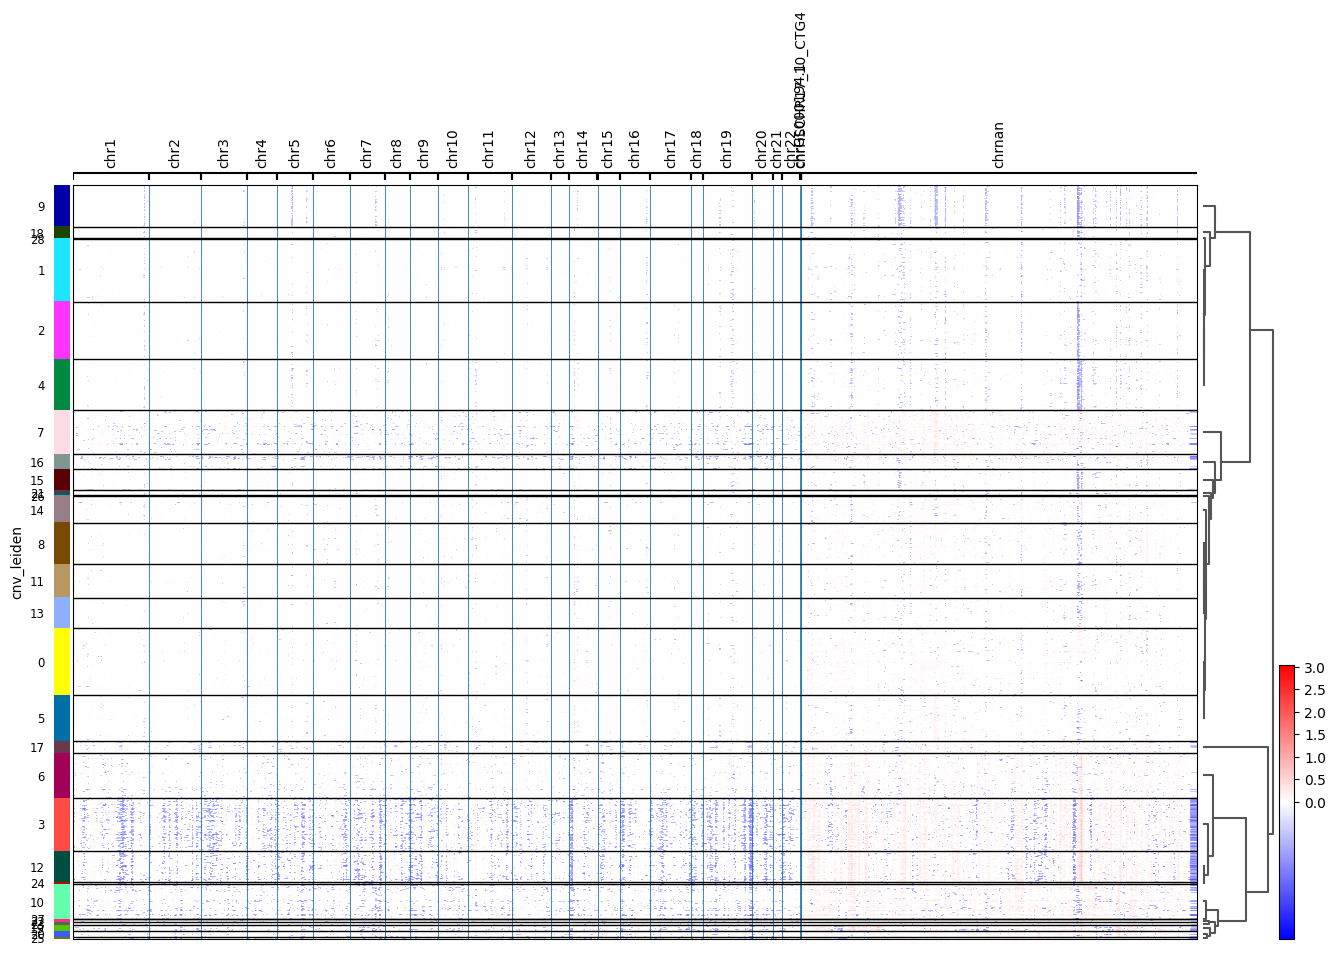

In [60]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


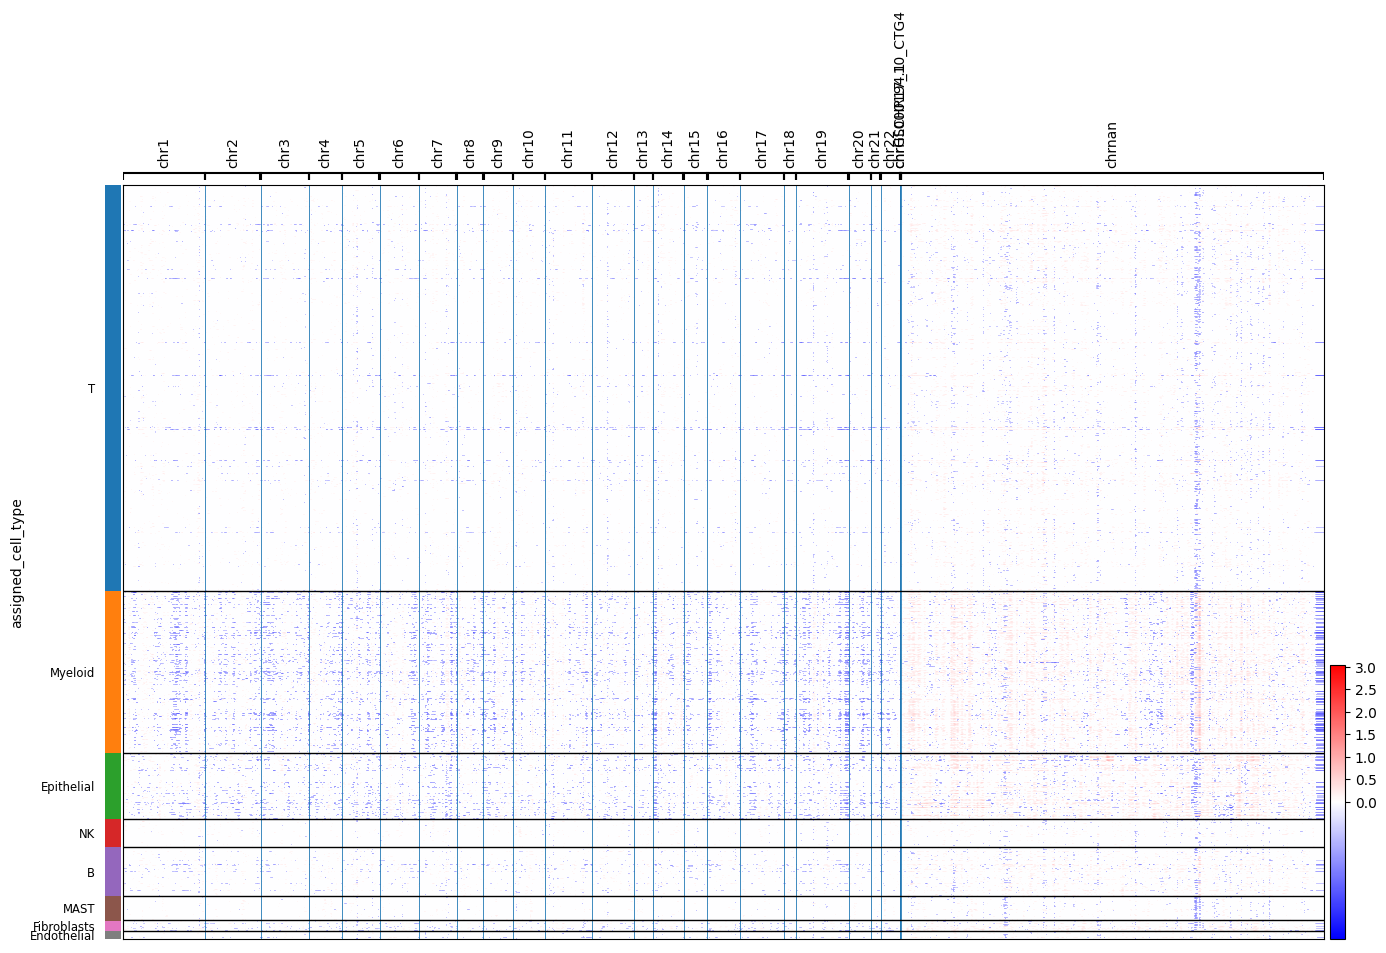

In [65]:
cnv.pl.chromosome_heatmap(adata, groupby="assigned_cell_type")

In [73]:
adata.obs['Histological subtype']

0         MIA
1         MIA
2         MIA
3         MIA
4         MIA
         ... 
488231    NaN
488232    NaN
488233    NaN
488234    NaN
488235    NaN
Name: Histological subtype, Length: 488236, dtype: category
Categories (15, object): ['Acinar predominant', 'Acinar+Lepidic+ Micropapillary', 'Acinar+Papillary', 'Lepidic', ..., 'Soild', 'Solid+Acinar', 'Solid+Acinar+Papillary', 'Unkown']

In [72]:
adata

AnnData object with n_obs × n_vars = 488236 × 33336
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'assigned_cell_type', 'Patient Number', 'Group', 'Sex', 'Age （years）', 'Current or former smoking', 'Cancer history', 'Tumor location', 'Tumor size（cm）', 'Pathology', 'Histological subtype', 'T stage', 'N stage', 'M stage', 'Pathological stage', 'cnv_leiden', 'cnv_score'
    var: 'chromosome', 'start', 'end'
    uns: 'cnv', 'cnv_neighbors', 'leiden', 'dendrogram_cnv_leiden', 'cnv_leiden_colors', 'assigned_cell_type_colors'
    obsm: 'X_tsne', 'X_umap', 'X_cnv', 'X_cnv_pca', 'X_pca', 'X_cnv_umap'
    layers: 'data'
    obsp: 'cnv_neighbors_distances', 'cnv_neighbors_connectivities'

In [66]:
%%time
#papermill_description=CLUSTERING

cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
IOStream.flush timed out
IOStream.flush timed out


CPU times: user 1h 26min 8s, sys: 27min 9s, total: 1h 53min 18s
Wall time: 1h 3min 57s


In [ ]:
if id_ == 'UKIM-V':
    del adata.obsm['surface_protein']

In [67]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 'chromosome' as categorical
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is depre

KeyError: 'Level_2_transfered_label'

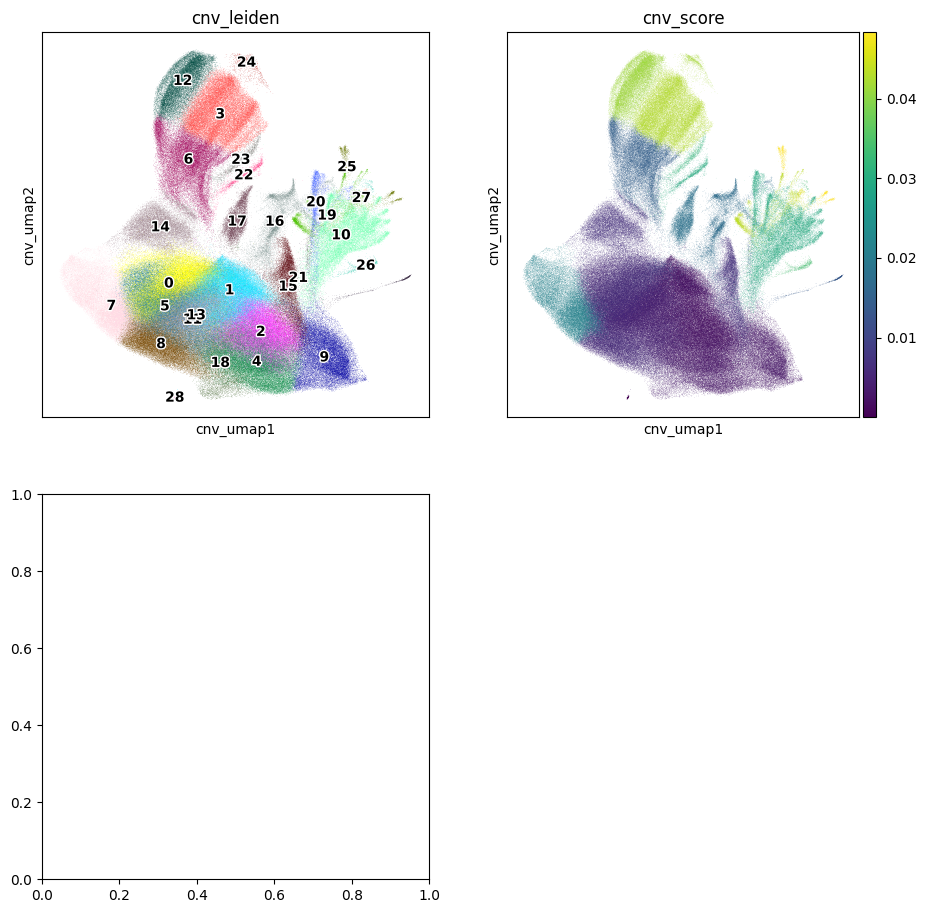

In [68]:
#papermill_description=PLOTS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="Level_2_transfered_label", ax=ax3)

In [ ]:
clusters_and_scores = adata.obs.loc[:, ['cnv_score','cnv_leiden']]
clusters_and_scores